### Урок 5. Задача оттока: варианты постановки, возможные способы решения

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [3]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
path = '/gdrive/MyDrive/MLBI/lesson_5/'

In [6]:
df = pd.read_csv(path+"Churn_Modelling.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [8]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


In [9]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [10]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scale', StandardScaler())
               
            ])
    final_transformers.append((cont_col, cont_transformer))

In [11]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42,class_weight={0:1,1:4} )),
])

In [14]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [15]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, preds)
fscore_rf = (2*precision_rf * recall_rf) / (precision_rf + recall_rf)
# locate the index of the largest f score
ix = np.argmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_rf[ix], 
                                                                        fscore_rf[ix],
                                                                        precision_rf[ix],
                                                                        recall_rf[ix]))
Random_Forest_Classifier = thresholds_rf[ix], fscore_rf[ix], precision_rf[ix], recall_rf[ix]



Best Threshold=0.350000, F-Score=0.639, Precision=0.628, Recall=0.650


Confusion matrix, without normalization
[[1801  190]
 [ 184  325]]


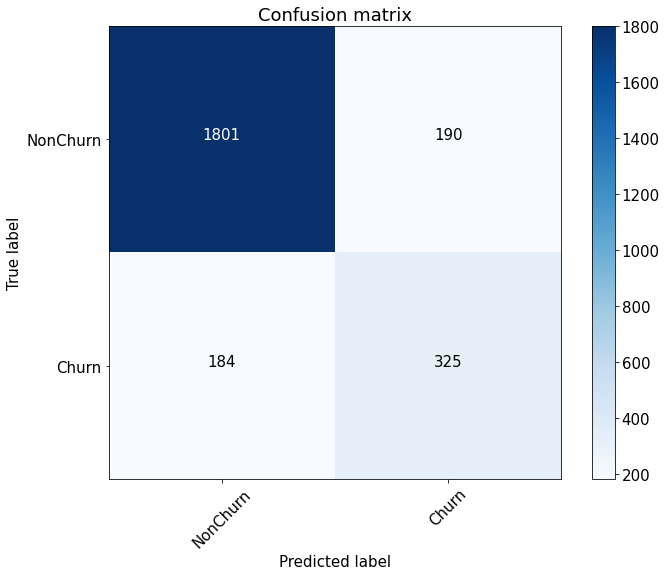

In [18]:

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, preds>thresholds_rf[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [19]:
pipeline_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C = 100,random_state = 42))
])

In [20]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [21]:
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]

In [22]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, preds_lr)
fscore_lr = (2*precision_lr * recall_lr) / (precision_lr + recall_lr)
# locate the index of the largest f score
ix = np.argmax(fscore_lr)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_lr[ix], 
                                                                        fscore_lr[ix],
                                                                        precision_lr[ix],
                                                                        recall_lr[ix]))

Logistic_Regression = thresholds_lr[ix], fscore_lr[ix], precision_lr[ix], recall_lr[ix]




Best Threshold=0.287203, F-Score=0.509, Precision=0.459, Recall=0.572


Confusion matrix, without normalization
[[1648  343]
 [ 219  290]]


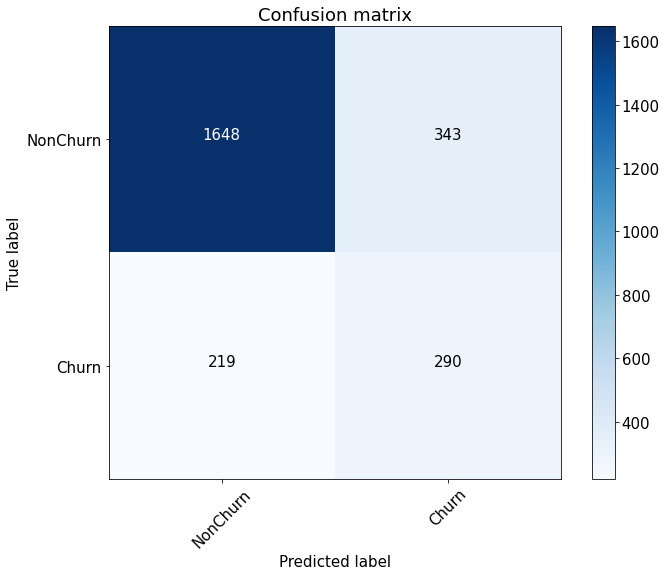

In [23]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lr = confusion_matrix(y_test, preds_lr>thresholds_lr[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_lr, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [24]:
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0))
])

In [25]:
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [26]:
preds_gb = pipeline_gb.predict_proba(X_test)[:, 1]

In [27]:
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test, preds_gb)
fscore_gb = (2*precision_gb * recall_gb) / (precision_gb + recall_gb)
# locate the index of the largest f score
ix = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix], 
                                                                        fscore_gb[ix],
                                                                        precision_gb[ix],
                                                                        recall_gb[ix]))
Gradient_Boosting_Classifier = thresholds_gb[ix], fscore_gb[ix], precision_gb[ix], recall_gb[ix]



Best Threshold=0.337000, F-Score=0.624, Precision=0.594, Recall=0.656


Confusion matrix, without normalization
[[1763  228]
 [ 176  333]]


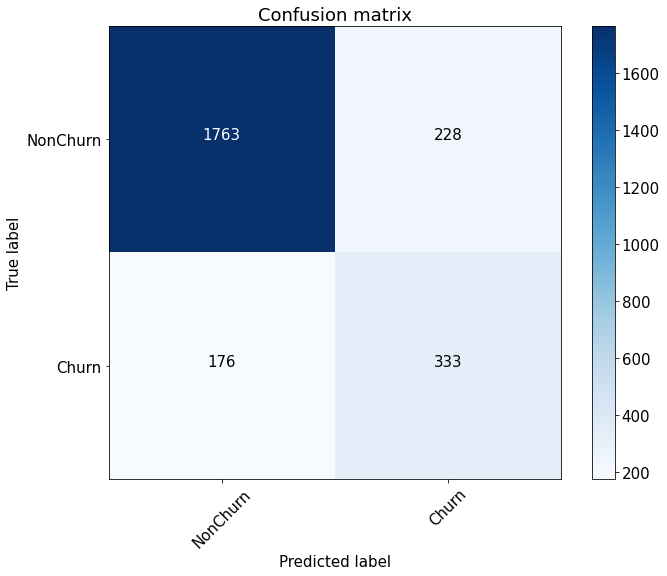

In [28]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, preds_gb>thresholds_gb[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [29]:
df1= pd.DataFrame({'metrics': ['thresholds', 'fscore', 'precision', 'recall'],
                   'LogisticRegression': Logistic_Regression, 'RandomForestClassifier': Random_Forest_Classifier, 'GradientBoostingClassifier': Gradient_Boosting_Classifier})
df1


,metrics,LogisticRegression,RandomForestClassifier,GradientBoostingClassifier
0,thresholds,0.287203,0.350000,0.337000
1,fscore,0.509186,0.638996,0.623716
2,precision,0.458991,0.628083,0.594306
3,recall,0.571709,0.650295,0.656189


Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [30]:
cnf_matrix_rf

array([[1801,  190],
       [ 184,  325]])

In [32]:
eff = (cnf_matrix_rf[0,0])*2 - (np.sum(cnf_matrix_rf[1,:]))*1
print('Экономическая эффективность', eff )

Экономическая эффективность 3093


(опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [33]:
params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

In [34]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.3,
 'classifier__min_samples_leaf': 1}

In [35]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.3, 
                                          min_samples_leaf=1, random_state=42, class_weight="balanced_subsample")),
])


In [37]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [38]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [39]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, preds)
fscore_rf = (2*precision_rf * recall_rf) / (precision_rf + recall_rf)
# locate the index of the largest f score
ix = np.argmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_rf[ix], 
                                                                        fscore_rf[ix],
                                                                        precision_rf[ix],
                                                                        recall_rf[ix]))
Random_Forest_Classifier = thresholds_rf[ix], fscore_rf[ix], precision_rf[ix], recall_rf[ix]

Best Threshold=0.360000, F-Score=0.639, Precision=0.640, Recall=0.639


Несколько непонятная ситуация образовалась в Jupyter Notebook. После применения новых (оптимальных) параметров получились следующие метрики: Best Threshold=0.980000, F-Score=nan, Precision=0.000, Recall=0.000. В Colab же все отлично (ячейка выше). В Jupyter Notebook пробовал в разных виртуальных окружениях.... ?

Confusion matrix, without normalization
[[1812  179]
 [ 190  319]]


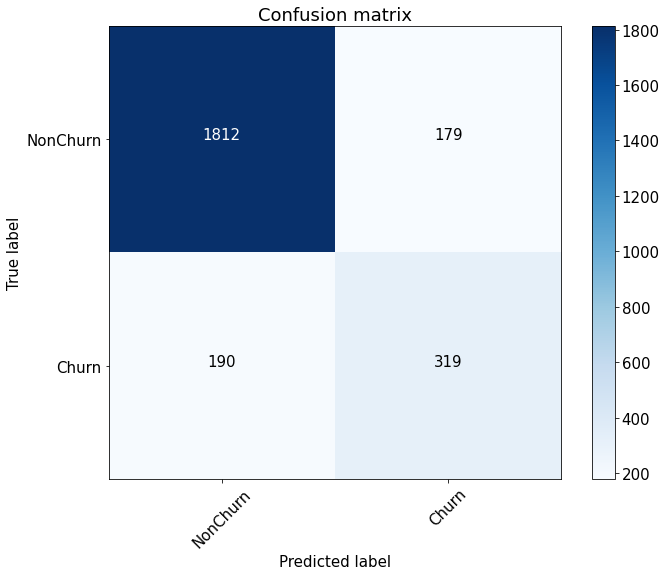

In [40]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, preds>thresholds_rf[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [41]:
cnf_matrix_rf


array([[1812,  179],
       [ 190,  319]])

(опционально) Еще раз провести оценку экономической эффективности

In [42]:
eff = (cnf_matrix_rf[0,0])*2 - np.sum(cnf_matrix_rf[1,:])*1
print('Экономическая эффективность', eff )

Экономическая эффективность 3115
